In [4]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from collections import Counter

# Para procesamiento de texto
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Para modelado de tópicos
from gensim.models import LdaSeqModel
from gensim.corpora import Dictionary

# Configuración inicial
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Descargar recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raula\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raula\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\raula\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\raula\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
# Cargar dataset
df = pd.read_csv('datos_filtrados.csv')

# Tomar un subset manejable (200 noticias de 2015-2016)
#mask = (df['datetime'] >= '2015-01-01') & (df['date'] <= '2016-12-31')
#df = df[mask].sample(n=200, random_state=42)

# Convertir fechas a datetime y ordenar
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

print("Dimensiones del dataset:", df.shape)
print("\nRango temporal:", df['datetime'].min(), "-", df['datetime'].max())


Dimensiones del dataset: (1608, 10)

Rango temporal: 2018-08-15 00:00:00 - 2018-10-20 23:00:00


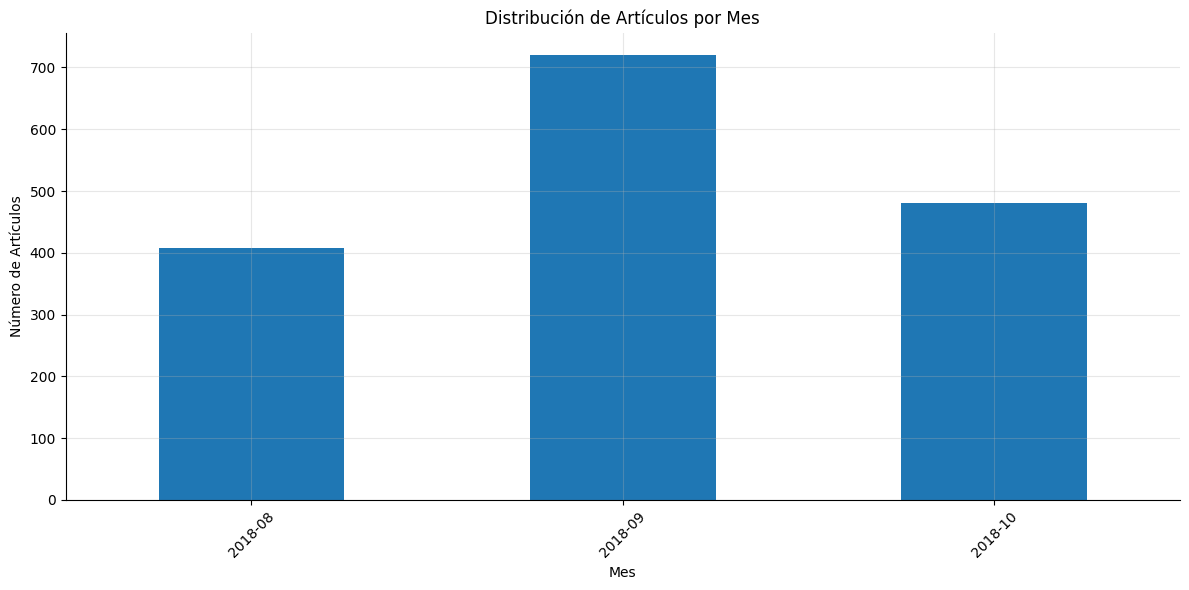

In [6]:
# Visualización de distribución temporal
plt.figure(figsize=(12, 6))
df['datetime'].dt.to_period('M').value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Artículos por Mes')
plt.xlabel('Mes')
plt.ylabel('Número de Artículos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
import ast

In [8]:
df['tweet_texts'] = df['tweet_texts'].apply(ast.literal_eval)

In [9]:
df['tweet_texts'][1]

['@Viictoriaduda Eu te amo bb,para de me desmerecer perto dos seus amigos :)',
 '@EdsonFurinho Obrigado Pedro, significa muito pra gente :)',
 'fingindo que tô cantando pra mamãe não me pegar chorando :D',
 'Riçao lindo, num sei tirar do anônimo, vc sabe quem é :) — Oi vamo https://t.co/DgGXhBh4yh',
 'Ei você! Você mesmo! Já assinou o nosso feed? É só procurar no seu agregador de Podcasts pelo ninguém aqui é nerd que vai estar lá :D #PodcastBR #PodcastBR #podosfera https://t.co/OaTGkwvmH4',
 'Pse pelo visto me enganei, 42 dias sem fumar cigarro lek, pior q eu vou mesmo fzr isso de vdd :) #infelizmentevivermais https://t.co/BHjw1q9B4Z',
 'Mimei o Lisa ... :) https://t.co/tHpa4KJBLi',
 '@sweetbobbypand @zoeybrownx a zoey parecia um et socorroKKKLKMJMKKKKKK e eu era a baleiazinha da casa :) nao mudou mta coisa',
 'toda semana glenda estourando o limite do cartao de credito :p',
 '@raissasrangel KKKKKKK brincadeirinha :)',
 '@AriProte Já quero ver kaiakajajakakkaka Tendi, foi só piada mesm

In [10]:
# prompt: junta cada elemento de la lista en en la columna tweet_texts para que sea un unico elemento, un string

df['tweet_texts_processed'] = df['tweet_texts'].apply(lambda x: ' '.join(x))
df['tweet_texts_processed'][1]

'@Viictoriaduda Eu te amo bb,para de me desmerecer perto dos seus amigos :) @EdsonFurinho Obrigado Pedro, significa muito pra gente :) fingindo que tô cantando pra mamãe não me pegar chorando :D Riçao lindo, num sei tirar do anônimo, vc sabe quem é :) — Oi vamo https://t.co/DgGXhBh4yh Ei você! Você mesmo! Já assinou o nosso feed? É só procurar no seu agregador de Podcasts pelo ninguém aqui é nerd que vai estar lá :D #PodcastBR #PodcastBR #podosfera https://t.co/OaTGkwvmH4 Pse pelo visto me enganei, 42 dias sem fumar cigarro lek, pior q eu vou mesmo fzr isso de vdd :) #infelizmentevivermais https://t.co/BHjw1q9B4Z Mimei o Lisa ... :) https://t.co/tHpa4KJBLi @sweetbobbypand @zoeybrownx a zoey parecia um et socorroKKKLKMJMKKKKKK e eu era a baleiazinha da casa :) nao mudou mta coisa toda semana glenda estourando o limite do cartao de credito :p @raissasrangel KKKKKKK brincadeirinha :) @AriProte Já quero ver kaiakajajakakkaka Tendi, foi só piada mesmo :) @LuigiTheBb Obg, Luigi. Acho que vou

In [11]:
def preprocess_text(text):
    """
    Preprocesa el texto para análisis de tópicos
    """
    # Inicializar herramientas
    stop_words = set(stopwords.words('portuguese'))
    lemmatizer = WordNetLemmatizer()

    # Convertir a minúsculas
    text = text.lower()

    # Eliminar caracteres especiales
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenizar
    tokens = word_tokenize(text)

    # Eliminar stopwords y lematizar
    tokens = [lemmatizer.lemmatize(token) for token in tokens
             if token not in stop_words and len(token) > 2]

    return tokens

# Combinar título y descripción para el análisis
#df['text'] = df['headline'] + ' ' + df['short_description']

# Aplicar preprocesamiento
df['processed_text'] = df['tweet_texts_processed'].apply(preprocess_text)



In [12]:
# Verificar el preprocesamiento
print("\nEjemplo de preprocesamiento:")
print("Original:", df['tweet_texts_processed'].iloc[1])
print("Procesado:", df['processed_text'].iloc[1])


Ejemplo de preprocesamiento:
Original: @Viictoriaduda Eu te amo bb,para de me desmerecer perto dos seus amigos :) @EdsonFurinho Obrigado Pedro, significa muito pra gente :) fingindo que tô cantando pra mamãe não me pegar chorando :D Riçao lindo, num sei tirar do anônimo, vc sabe quem é :) — Oi vamo https://t.co/DgGXhBh4yh Ei você! Você mesmo! Já assinou o nosso feed? É só procurar no seu agregador de Podcasts pelo ninguém aqui é nerd que vai estar lá :D #PodcastBR #PodcastBR #podosfera https://t.co/OaTGkwvmH4 Pse pelo visto me enganei, 42 dias sem fumar cigarro lek, pior q eu vou mesmo fzr isso de vdd :) #infelizmentevivermais https://t.co/BHjw1q9B4Z Mimei o Lisa ... :) https://t.co/tHpa4KJBLi @sweetbobbypand @zoeybrownx a zoey parecia um et socorroKKKLKMJMKKKKKK e eu era a baleiazinha da casa :) nao mudou mta coisa toda semana glenda estourando o limite do cartao de credito :p @raissasrangel KKKKKKK brincadeirinha :) @AriProte Já quero ver kaiakajajakakkaka Tendi, foi só piada mesmo 

In [13]:
# Crear diccionario
dictionary = Dictionary(df['processed_text'])

# Filtrar términos poco frecuentes o muy comunes
dictionary.filter_extremes(no_below=5, no_above=0.5)
print("\nTamaño del vocabulario:", len(dictionary))

# Crear corpus
corpus = [dictionary.doc2bow(doc) for doc in df['processed_text']]

# Preparar time_slices (documentos por mes)
df['month'] = df['datetime'].dt.to_period('M')
time_slices = df.groupby('month').size().tolist()
print("\nNúmero de periodos temporales:", len(time_slices))



Tamaño del vocabulario: 47607

Número de periodos temporales: 3


In [15]:
# Configurar y entrenar modelo
num_topics = 5  # Número de tópicos a detectar
chain_variance = 0.100  # Controla la suavidad de la evolución temporal

dtm = LdaSeqModel(
    corpus=corpus,
    time_slice=time_slices,
    num_topics=num_topics,
    id2word=dictionary,
    chain_variance=chain_variance,
    passes=10
)


c:\Users\raula\AppData\Local\Programs\Python\Python310\lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\Users\raula\AppData\Local\Programs\Python\Python310\lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)
c:\Users\raula\AppData\Local\Programs\Python\Python310\lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\Users\raula\AppData\Local\Programs\Python\Python310\lib\site-packages\gensim\models\ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
c:\Users\raula\AppData\Local\Programs\Python\Python310\lib\site-packages\gensim\

In [16]:
def print_topic_evolution(model, periods=None):
    """
    Imprime la evolución de tópicos a lo largo del tiempo
    """
    num_time_slices = len(time_slices)
    for t in range(num_time_slices):
        print(f"\nPeríodo {t}:")
        for topic in range(model.num_topics):
            # La nueva sintaxis no usa el parámetro 'topics'
            top_terms = model.print_topics(time=t)[topic]
            print(f"Tópico {topic}: {top_terms[:5]}")

# Mostrar evolución de tópicos
print_topic_evolution(dtm)


Período 0:
Tópico 0: [('dia', 0.017401913681494595), ('pra', 0.017166979850785417), ('bom', 0.010489373272524128), ('vou', 0.009215204168965369), ('vai', 0.0077690861642834425)]
Tópico 1: [('pra', 0.013974089030100677), ('dia', 0.008591413476480339), ('vou', 0.0078299061818954), ('bem', 0.007542347002789349), ('voc', 0.007028690620741008)]
Tópico 2: [('voc', 0.027731912843179843), ('agora', 0.022113305538185857), ('algum', 0.018865467172670385), ('pra', 0.014040224087494899), ('falta', 0.01385832956770457)]
Tópico 3: [('queria', 0.01970140266736145), ('pra', 0.019594308979480345), ('triste', 0.00848145140973452), ('vou', 0.007755112411400871), ('amo', 0.007321563595985502)]
Tópico 4: [('pra', 0.01749406770746402), ('queria', 0.01738995818909345), ('amo', 0.014593781940868897), ('triste', 0.01093567287190327), ('vou', 0.00996650101699751)]

Período 1:
Tópico 0: [('dia', 0.018086068517178235), ('pra', 0.0159399007516811), ('vou', 0.009335637756501407), ('bom', 0.009229748450254642), ('t

In [17]:
# Guardar el modelo
dtm.save('dtm_model')

# Exportar tópicos por periodo a un CSV
topics_over_time = {}
num_time_slices = len(time_slices)

for t in range(num_time_slices):
    # Obtener tópicos para este período
    topics = dtm.print_topics(time=t)

    # Guardar cada tópico
    period_topics = {}
    for topic_id, topic_terms in enumerate(topics):
        period_topics[f'Topic_{topic_id}'] = topic_terms[1]  # topic_terms[1] contiene los términos

    topics_over_time[t] = period_topics

# Convertir a DataFrame
topics_df = pd.DataFrame.from_dict(topics_over_time, orient='index')

# Guardar en CSV
topics_df.to_csv('topics_evolution.csv')

print("\nResultados guardados:")
print("- Modelo: dtm_model")
print("- Evolución de tópicos: topics_evolution.csv")


Resultados guardados:
- Modelo: dtm_model
- Evolución de tópicos: topics_evolution.csv
